<a href="https://colab.research.google.com/github/binodmathews93/GUVI-DeepLearning/blob/main/VectorisedGDAlgorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook 
import seaborn as sns
import imageio
import time
from matplotlib import animation, rc
from IPython.display import HTML


from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

In [ ]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

In [ ]:
np.random.seed(0)

## Generate data

In [ ]:
data, labels = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=0)
print(data.shape, labels.shape)

(1000, 2) (1000,)


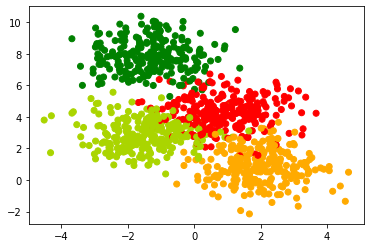

In [ ]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [ ]:
labels_orig = labels
labels = np.mod(labels_orig, 2)

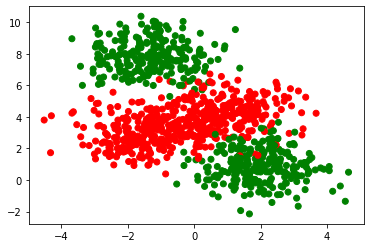

In [ ]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

## Multi class classification

In [ ]:
Xm_train, Xm_val, Ym_train, Ym_val = train_test_split(data, labels_orig, stratify=labels_orig, random_state=0)
print(Xm_train.shape, Xm_val.shape, labels_orig.shape)

(750, 2) (250, 2) (1000,)


In [ ]:
enc = OneHotEncoder()
# 0 -> (1, 0, 0, 0), 1 -> (0, 1, 0, 0), 2 -> (0, 0, 1, 0), 3 -> (0, 0, 0, 1)
y_OH_train = enc.fit_transform(np.expand_dims(Ym_train,1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Ym_val,1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)

(750, 4) (250, 4)


In [ ]:
W1 = np.random.randn(2,2)
W2 = np.random.randn(2,4)
print(W1)
print(W2)

[[1.76405235 0.40015721]
 [0.97873798 2.2408932 ]]
[[ 1.86755799 -0.97727788  0.95008842 -0.15135721]
 [-0.10321885  0.4105985   0.14404357  1.45427351]]


## Binary classification

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify=labels, random_state=0)
print(X_train.shape, X_val.shape, labels_orig.shape)

(750, 2) (250, 2) (1000,)


In [ ]:
Ws1 = np.random.randn(2,2)
Ws2 = np.random.randn(2,1)
print(Ws1)
print(Ws2)

[[ 0.95008842 -0.15135721]
 [-0.10321885  0.4105985 ]]
[[0.14404357]
 [1.45427351]]


## FF Class

In [ ]:
class FFNetwork:
  
  def __init__(self, W1, W2):
        
    self.params={}
    self.params["W1"]=W1.copy()
    self.params["W2"]=W2.copy()
    self.params["B1"]=np.zeros((1,2))
    self.params["B2"]=np.zeros((1,1))

    self.w1_h = []
    self.w2_h = []

    self.num_layers=2
    self.gradients={}
    self.update_params={}
    self.prev_update_params={}
    for i in range(1,self.num_layers+1):
      self.update_params["v_w"+str(i)]=0
      self.update_params["v_b"+str(i)]=0
      self.update_params["m_b"+str(i)]=0
      self.update_params["m_w"+str(i)]=0
      self.prev_update_params["v_w"+str(i)]=0
      self.prev_update_params["v_b"+str(i)]=0
  
  def forward_activation(self, X): 
    return 1.0/(1.0 + np.exp(-X))
      
  def grad_activation(self, X):
    return X*(1-X) 
  
  def forward_pass(self, X, params = None):
    if params is None:
        params = self.params
    self.A1 = np.matmul(X, params["W1"]) + params["B1"] # (N, 2) * (2, 2) -> (N, 2)
    self.H1 = self.forward_activation(self.A1) # (N, 2)
    self.A2 = np.matmul(self.H1, params["W2"]) + params["B2"] # ((N, 2) * (2, 1) -> (N, 1)
    self.H2 = self.forward_activation(self.A2) # (N, 1)
    return self.H2

  def grad(self, X, Y, params = None):
    if params is None:
      params = self.params 
      
    self.forward_pass(X, params)
    m = X.shape[0]
    self.gradients["dA2"] = self.H2 - Y # (N, 1)
    self.gradients["dW2"] = np.matmul(self.H1.T, self.gradients["dA2"]) # (2, N) * (N, 1) -> (2, 1)
    self.gradients["dB2"] = np.sum(self.gradients["dA2"], axis=0).reshape(1, -1) # (N, 1) -> (1, 1)
    self.gradients["dH1"] = np.matmul(self.gradients["dA2"], params["W2"].T) # (N, 1) * (1, 2) -> (N, 2)
    self.gradients["dA1"] = np.multiply(self.gradients["dH1"], self.grad_activation(self.H1)) # (N, 2) .* (N, 2) -> (N, 2)
    self.gradients["dW1"] = np.matmul(X.T, self.gradients["dA1"]) # (2, N) * (N, 2) -> (2, 2)
    self.gradients["dB1"] = np.sum(self.gradients["dA1"], axis=0).reshape(1, -1) # (N, 2) -> (1, 2)
    
  def fit(self, X, Y, epochs=1, algo= "GD", display_loss=False, 
          eta=1, mini_batch_size=100, eps=1e-8,  
          beta=0.9, beta1=0.9, beta2=0.9, gamma=0.9 ):
      
    if display_loss:
      loss = {}
    for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      m = X.shape[0]
      
      if algo == "GD":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/m)
          
      elif algo == "MiniBatch":
        for k in range(0,m,mini_batch_size):
          self.grad(X[k:k+mini_batch_size], Y[k:k+mini_batch_size])
          for i in range(1,self.num_layers+1):
            self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/mini_batch_size)
            self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/mini_batch_size)
            
      elif algo == "Momentum":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] = gamma *self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
          self.update_params["v_b"+str(i)] = gamma *self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)]/m)
          self.params["W"+str(i)] -= self.update_params["v_w"+str(i)]
          self.params["B"+str(i)] -= self.update_params["v_b"+str(i)]  
          
      elif algo == "NAG":
        temp_params = {}
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)]=gamma*self.prev_update_params["v_w"+str(i)]
          self.update_params["v_b"+str(i)]=gamma*self.prev_update_params["v_b"+str(i)]
          temp_params["W"+str(i)]=self.params["W"+str(i)]-self.update_params["v_w"+str(i)]
          temp_params["B"+str(i)]=self.params["B"+str(i)]-self.update_params["v_b"+str(i)]
        self.grad(X,Y,temp_params)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] = gamma *self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
          self.update_params["v_b"+str(i)] = gamma *self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)]/m)
          self.params["W"+str(i)] -= eta * (self.update_params["v_w"+str(i)])
          self.params["B"+str(i)] -= eta * (self.update_params["v_b"+str(i)]) 
        self.prev_update_params=self.update_params 
        
      elif algo == "AdaGrad":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] += (self.gradients["dW"+str(i)]/m)**2
          self.update_params["v_b"+str(i)] += (self.gradients["dB"+str(i)]/m)**2
          self.params["W"+str(i)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i)])+eps)) * (self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i)])+eps)) * (self.gradients["dB"+str(i)]/m)
      
      elif algo == "RMSProp":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] = beta*self.update_params["v_w"+str(i)] +(1-beta)*((self.gradients["dW"+str(i)]/m)**2)
          self.update_params["v_b"+str(i)] = beta*self.update_params["v_b"+str(i)] +(1-beta)*((self.gradients["dB"+str(i)]/m)**2)
          self.params["W"+str(i)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i)]+eps)))*(self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i)]+eps)))*(self.gradients["dB"+str(i)]/m)
      
      elif algo == "Adam":
        self.grad(X, Y)
        num_updates=0
        for i in range(1,self.num_layers+1):
          num_updates+=1
          self.update_params["m_w"+str(i)]=beta1*self.update_params["m_w"+str(i)]+(1-beta1)*(self.gradients["dW"+str(i)]/m)
          self.update_params["v_w"+str(i)]=beta2*self.update_params["v_w"+str(i)]+(1-beta2)*((self.gradients["dW"+str(i)]/m)**2)
          m_w_hat=self.update_params["m_w"+str(i)]/(1-np.power(beta1,num_updates))
          v_w_hat=self.update_params["v_w"+str(i)]/(1-np.power(beta2,num_updates))
          self.params["W"+str(i)] -=(eta/np.sqrt(v_w_hat+eps))*m_w_hat
          
          self.update_params["m_b"+str(i)]=beta1*self.update_params["m_b"+str(i)]+(1-beta1)*(self.gradients["dB"+str(i)]/m)
          self.update_params["v_b"+str(i)]=beta2*self.update_params["v_b"+str(i)]+(1-beta2)*((self.gradients["dB"+str(i)]/m)**2)
          m_b_hat=self.update_params["m_b"+str(i)]/(1-np.power(beta1,num_updates))
          v_b_hat=self.update_params["v_b"+str(i)]/(1-np.power(beta2,num_updates))
          self.params["B"+str(i)] -=(eta/np.sqrt(v_b_hat+eps))*m_b_hat
      if display_loss:
        Y_pred = self.predict(X)
        loss[num_epoch] = log_loss(Y, Y_pred)
    
    if display_loss:
      plt.plot(np.array(list(loss.values())).astype(float), '-o', markersize=5)
      plt.xlabel('Epochs')
      plt.ylabel('Log Loss')
      plt.show()
      
  
  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return np.array(Y_pred).squeeze()

In [ ]:
def print_accuracy():    
    Y_pred_train = model.predict(X_train)
    Y_pred_train = (Y_pred_train >= 0.5).astype("int").ravel()
    Y_pred_val = model.predict(X_val)
    Y_pred_val = (Y_pred_val >= 0.5).astype("int").ravel()
    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    print("Training accuracy", round(accuracy_train, 4))
    print("Validation accuracy", round(accuracy_val, 4))
    
    if False:
      plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
      plt.show()

####Trying out different Optimization Algos

{'W1': array([[ 0.95008842, -0.15135721],
       [-0.10321885,  0.4105985 ]]), 'W2': array([[0.14404357],
       [1.45427351]]), 'B1': array([[0., 0.]]), 'B2': array([[0.]])}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


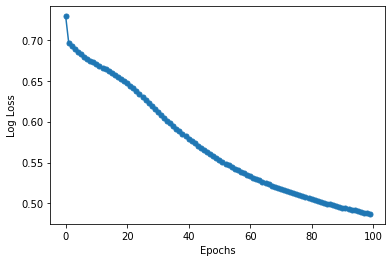

Training accuracy 0.704
Validation accuracy 0.676
CPU times: user 287 ms, sys: 6.71 ms, total: 293 ms
Wall time: 317 ms


In [ ]:
%%time
model = FFNetwork(Ws1, Ws2)
model.fit(X_train, np.expand_dims(Y_train,1), epochs=100, eta=1, algo="GD", display_loss=True)
print_accuracy()

{'W1': array([[ 0.95008842, -0.15135721],
       [-0.10321885,  0.4105985 ]]), 'W2': array([[0.14404357],
       [1.45427351]]), 'B1': array([[0., 0.]]), 'B2': array([[0.]])}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


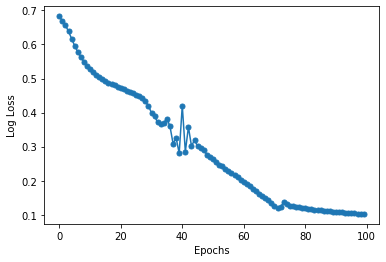

Training accuracy 0.9693
Validation accuracy 0.948
CPU times: user 337 ms, sys: 5.83 ms, total: 343 ms
Wall time: 351 ms


In [ ]:

%%time
model = FFNetwork(Ws1, Ws2)
model.fit(X_train, np.expand_dims(Y_train,1), epochs=100, eta=1, algo="MiniBatch", mini_batch_size=128, display_loss=True)
print_accuracy()

{'W1': array([[ 0.95008842, -0.15135721],
       [-0.10321885,  0.4105985 ]]), 'W2': array([[0.14404357],
       [1.45427351]]), 'B1': array([[0., 0.]]), 'B2': array([[0.]])}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


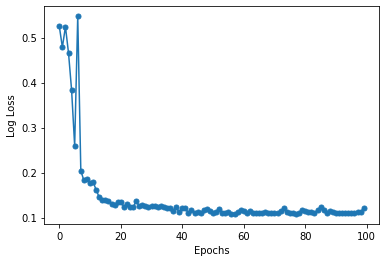

Training accuracy 0.9667
Validation accuracy 0.944
CPU times: user 972 ms, sys: 5.14 ms, total: 977 ms
Wall time: 992 ms


In [ ]:
%%time
model = FFNetwork(Ws1, Ws2)
model.fit(X_train, np.expand_dims(Y_train,1), epochs=100, eta=1, algo="MiniBatch", mini_batch_size=8, display_loss=True)
print_accuracy()

{'W1': array([[ 0.95008842, -0.15135721],
       [-0.10321885,  0.4105985 ]]), 'W2': array([[0.14404357],
       [1.45427351]]), 'B1': array([[0., 0.]]), 'B2': array([[0.]])}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


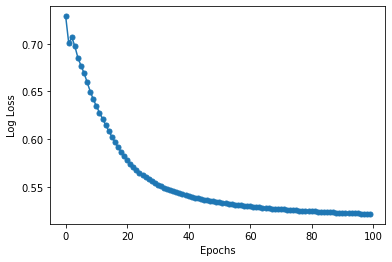

Training accuracy 0.728
Validation accuracy 0.716
CPU times: user 277 ms, sys: 12.1 ms, total: 289 ms
Wall time: 320 ms


In [ ]:
%%time
model = FFNetwork(Ws1, Ws2)
model.fit(X_train, np.expand_dims(Y_train,1), epochs=100, eta=1, algo="Momentum", gamma=0.5, display_loss=True)
print_accuracy()

{'W1': array([[ 0.95008842, -0.15135721],
       [-0.10321885,  0.4105985 ]]), 'W2': array([[0.14404357],
       [1.45427351]]), 'B1': array([[0., 0.]]), 'B2': array([[0.]])}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


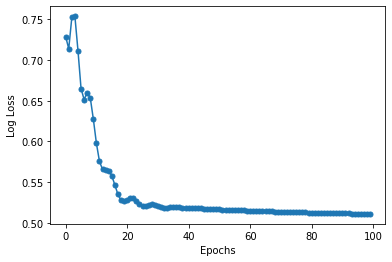

Training accuracy 0.7333
Validation accuracy 0.716
CPU times: user 297 ms, sys: 6.24 ms, total: 303 ms
Wall time: 328 ms


In [ ]:
%%time
model = FFNetwork(Ws1, Ws2)
model.fit(X_train, np.expand_dims(Y_train,1), epochs=100, eta=1, algo="Momentum", gamma=0.9, display_loss=True)
print_accuracy()

{'W1': array([[ 0.95008842, -0.15135721],
       [-0.10321885,  0.4105985 ]]), 'W2': array([[0.14404357],
       [1.45427351]]), 'B1': array([[0., 0.]]), 'B2': array([[0.]])}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


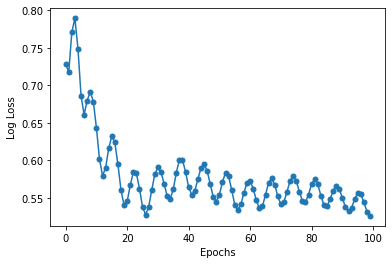

Training accuracy 0.704
Validation accuracy 0.7
CPU times: user 388 ms, sys: 15.6 ms, total: 404 ms
Wall time: 417 ms


In [ ]:
%%time
model = FFNetwork(Ws1, Ws2)
model.fit(X_train, np.expand_dims(Y_train,1), epochs=100, eta=1, algo="Momentum", gamma=0.99, display_loss=True)
print_accuracy()

{'W1': array([[ 0.95008842, -0.15135721],
       [-0.10321885,  0.4105985 ]]), 'W2': array([[0.14404357],
       [1.45427351]]), 'B1': array([[0., 0.]]), 'B2': array([[0.]])}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


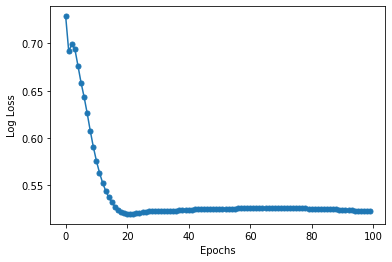

Training accuracy 0.7173
Validation accuracy 0.712
CPU times: user 290 ms, sys: 7.56 ms, total: 298 ms
Wall time: 304 ms


In [ ]:
%%time
model = FFNetwork(Ws1, Ws2)
model.fit(X_train, np.expand_dims(Y_train,1), epochs=100, eta=1, algo="NAG", gamma=0.99, display_loss=True)
print_accuracy()

{'W1': array([[ 0.95008842, -0.15135721],
       [-0.10321885,  0.4105985 ]]), 'W2': array([[0.14404357],
       [1.45427351]]), 'B1': array([[0., 0.]]), 'B2': array([[0.]])}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


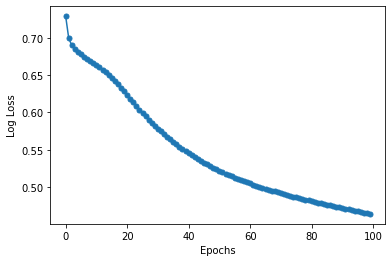

Training accuracy 0.7507
Validation accuracy 0.68
CPU times: user 285 ms, sys: 8.83 ms, total: 294 ms
Wall time: 310 ms


In [ ]:
%%time
model = FFNetwork(Ws1, Ws2)
model.fit(X_train, np.expand_dims(Y_train,1), epochs=100, eta=1, algo="NAG", gamma=0.5, display_loss=True)
print_accuracy()

{'W1': array([[ 0.95008842, -0.15135721],
       [-0.10321885,  0.4105985 ]]), 'W2': array([[0.14404357],
       [1.45427351]]), 'B1': array([[0., 0.]]), 'B2': array([[0.]])}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


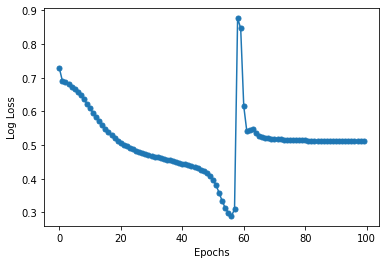

Training accuracy 0.7333
Validation accuracy 0.716
CPU times: user 312 ms, sys: 8.97 ms, total: 321 ms
Wall time: 332 ms


In [ ]:
%%time
model = FFNetwork(Ws1, Ws2)
model.fit(X_train, np.expand_dims(Y_train,1), epochs=100, eta=1, algo="NAG", gamma=0.9, display_loss=True)
print_accuracy()

{'W1': array([[ 0.95008842, -0.15135721],
       [-0.10321885,  0.4105985 ]]), 'W2': array([[0.14404357],
       [1.45427351]]), 'B1': array([[0., 0.]]), 'B2': array([[0.]])}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


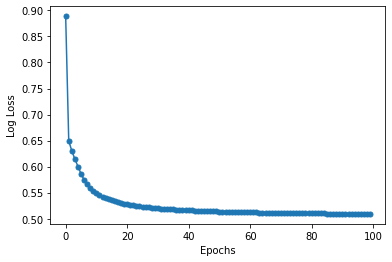

Training accuracy 0.7347
Validation accuracy 0.716
CPU times: user 298 ms, sys: 3.05 ms, total: 301 ms
Wall time: 320 ms


In [ ]:
%%time
model = FFNetwork(Ws1, Ws2)
model.fit(X_train, np.expand_dims(Y_train,1), epochs=100, eta=1, algo="AdaGrad", display_loss=True)
print_accuracy()

{'W1': array([[ 0.95008842, -0.15135721],
       [-0.10321885,  0.4105985 ]]), 'W2': array([[0.14404357],
       [1.45427351]]), 'B1': array([[0., 0.]]), 'B2': array([[0.]])}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


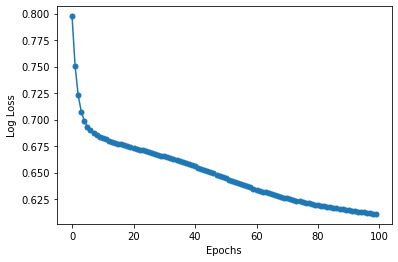

Training accuracy 0.6707
Validation accuracy 0.628
CPU times: user 305 ms, sys: 12.7 ms, total: 318 ms
Wall time: 330 ms


In [ ]:
%%time
model = FFNetwork(Ws1, Ws2)
model.fit(X_train, np.expand_dims(Y_train,1), epochs=100, eta=.1, algo="AdaGrad", display_loss=True)
print_accuracy()

{'W1': array([[ 0.95008842, -0.15135721],
       [-0.10321885,  0.4105985 ]]), 'W2': array([[0.14404357],
       [1.45427351]]), 'B1': array([[0., 0.]]), 'B2': array([[0.]])}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


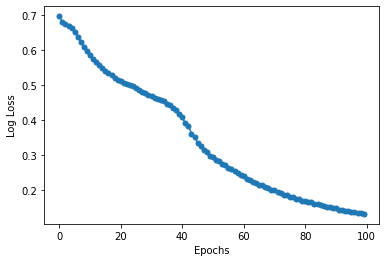

Training accuracy 0.9693
Validation accuracy 0.948
CPU times: user 302 ms, sys: 4.57 ms, total: 306 ms
Wall time: 326 ms


In [ ]:
%%time
model = FFNetwork(Ws1, Ws2)
model.fit(X_train, np.expand_dims(Y_train,1), epochs=100, eta=.1, algo="RMSProp", beta=0.9, display_loss=True)
print_accuracy()

{'W1': array([[ 0.95008842, -0.15135721],
       [-0.10321885,  0.4105985 ]]), 'W2': array([[0.14404357],
       [1.45427351]]), 'B1': array([[0., 0.]]), 'B2': array([[0.]])}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


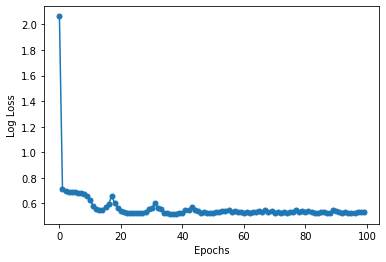

Training accuracy 0.7253
Validation accuracy 0.712
CPU times: user 305 ms, sys: 1.87 ms, total: 306 ms
Wall time: 333 ms


In [ ]:
%%time
model = FFNetwork(Ws1, Ws2)
model.fit(X_train, np.expand_dims(Y_train,1), epochs=100, eta=.9, algo="RMSProp", beta=0.9, display_loss=True)
print_accuracy()

{'W1': array([[ 0.95008842, -0.15135721],
       [-0.10321885,  0.4105985 ]]), 'W2': array([[0.14404357],
       [1.45427351]]), 'B1': array([[0., 0.]]), 'B2': array([[0.]])}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


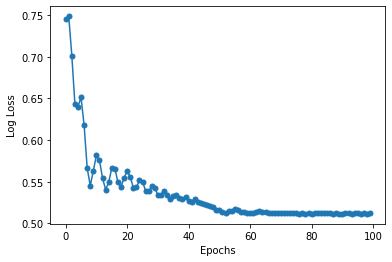

Training accuracy 0.7173
Validation accuracy 0.704
CPU times: user 307 ms, sys: 8.29 ms, total: 316 ms
Wall time: 335 ms


In [ ]:
%%time
model = FFNetwork(Ws1, Ws2)
model.fit(X_train, np.expand_dims(Y_train,1), epochs=100, eta=.9, algo="Adam", beta=0.9, display_loss=True)
print_accuracy()

{'W1': array([[ 0.95008842, -0.15135721],
       [-0.10321885,  0.4105985 ]]), 'W2': array([[0.14404357],
       [1.45427351]]), 'B1': array([[0., 0.]]), 'B2': array([[0.]])}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


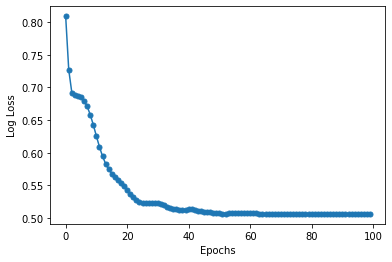

Training accuracy 0.732
Validation accuracy 0.712
CPU times: user 315 ms, sys: 7.73 ms, total: 322 ms
Wall time: 337 ms


In [ ]:
%%time
model = FFNetwork(Ws1, Ws2)
model.fit(X_train, np.expand_dims(Y_train,1), epochs=100, eta=.1, algo="Adam", beta=0.9, display_loss=True)
print_accuracy()